<a href="https://colab.research.google.com/github/Mostofa-Najmus-Sakib/Data-Science-CS533/blob/main/Assisgnment4/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Classification Fairness
# CS 533 Fall 2019


## Requirements

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import glob
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve

In [ ]:
#conda install -c conda-forge scikit-plot

## Data Cleaning

In [ ]:
data = pd.read_csv("compas-scores-two-years.csv")
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
data1 = data[(data['days_b_screening_arrest'] <=30) & (data['days_b_screening_arrest'] >= -30)
           & (data['is_recid'] != -1) & (data['c_charge_degree'] != 0) & (data['score_text'] != 'N/A')]

In [ ]:
def FPrate(score1, score2, xx):
    fpr, tpr, _ = roc_curve(data1[score1], data1[score2], pos_label=xx)
    return fpr
def TPrate(score1, score2, xx):
    fpr, tpr, _ = roc_curve(data1[score1], data1[score2], pos_label=xx)
    return tpr
fpr = []
tpr = []
ran = range(0, 12, 1)
for x in range(1, 12, 1):
    fpr.append(FPrate('decile_score', 'is_recid', x))
    tpr.append(TPrate('decile_score', 'is_recid', x))
fpr = pd.DataFrame(fpr)
tpr = pd.DataFrame(tpr)
tpData = pd.DataFrame()
tpData['fpr'] = fpr.iloc[:,1]
tpData['tpr'] = tpr.iloc[:,1]
tpData

C:\Users\Sajon_PC\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,fpr,tpr
0,0.550553,0.233281
1,0.504673,0.352798
2,0.492489,0.415765
3,0.486015,0.471471
4,0.481574,0.512027
5,0.472267,0.614367
6,0.470930,0.639113
7,0.464708,0.754762
8,0.465751,0.740476
9,0.467110,0.819079


## Part 1: ProPublica Replication
In the first part of this assignment, you will reproduce part of ProPublica’s analysis on racial disparities in the impact of the risk assessment tool.


### 1.3 — Basic Accuracy Analysis

Start by doing some basic analysis of the accuracy of the COMPAS classifier:
> 1.3.1 Plot ROC curves for recidivism and violent recidivism. Use the decile scores (decile_score and v_decile_score) as the predictor.

The below code takes in the input of is_recid which is the whether the defendent recidiviated along with the defandants COMPAS decile score for recividism to setup the roc_curve fucntion to calculate the roc curve.
Similar thing has been done for is_violent_recid which is the whether the defendent commited a violent crime along with the defandants COMPAS decile score for violent recividism.
Later both for the general and the violent we prepared the ROC curve

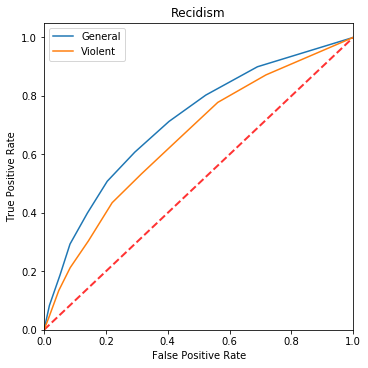

In [ ]:
data1.loc[:, ['is_recid', 'decile_score']]
fig, axs = plt.subplots(figsize=(5, 5), constrained_layout=True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
fpr, tpr, _ = metrics.roc_curve(data1['is_recid'], data1['decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='General')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', alpha=.8)
axs.set(title = 'Recidism', xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
fpr, tpr, _ = metrics.roc_curve(data['is_violent_recid'], data['v_decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='Violent')

plt.legend()
plt.show();

An incredibly useful tool in evaluating and comparing predictive models is the ROC curve. The above plot shows that General one can predict the model better in compare to the violent one. Because that one is more curved towards TP rate portion. This is because the sensitivity or recall value is higher compared to the false positive rate

> 1.3.2 Compute the precision (Positive Predictive Value), recall, false positive rate, and false negative rate for predicting both recidivism and violent recidivism, using ‘High Risk’ as the threshold for ‘will recidivate’.

**Calculation for general recividism**

We need to select from the dataset for score_text where the defandant compas risk score is only High

In [ ]:
st = data1['score_text'] == 'High'
st = st*1
st = pd.DataFrame(st)

Lets take only the is_recid column data only in a seperate variable

In [ ]:
is_recid = pd.DataFrame(data1['is_recid'])

Calculation of consusion matrix using the above two varaibles for the General case 

In [ ]:
confusion_matrix = pd.crosstab(data1['is_recid'], st['score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,2915,267
1,2113,877


From the confusion matrix calculation of Precision, recall, false positive rate and false negative rate for the general case

In [ ]:
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print('Recall is: ', recall)
print('precsiion is: ', pre)
print('Fals Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)

Recall is:  0.29331103678929765
precsiion is:  0.7666083916083916
Fals Positive Rate is:  0.08390949088623507
False Negative Rate is:  0.7066889632107023


**Calculation for violent recividism**

We need to select from the dataset for v_score_text where the defandant compas risk score is only High

In [ ]:
st2 = data1['v_score_text'] == 'High'
st2 = st2*1
st2 = pd.DataFrame(st2)
st2.head(20)
is_violent_recid = pd.DataFrame(data1['is_violent_recid'])

In [ ]:
confusion_matrix = pd.crosstab(data1['is_violent_recid'], st2['v_score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,5038,442
1,550,142


In [ ]:
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print('Recall is: ', recall)
print('precsiion is: ', pre)
print('Fals Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)

Recall is:  0.20520231213872833
precsiion is:  0.24315068493150685
Fals Positive Rate is:  0.08065693430656934
False Negative Rate is:  0.7947976878612717


### 1.4 — Racial Disparity

Now we want to look at racial disparities; we will consider Caucasian, Black, and Hispanic.



> 1.4.1 Draw a bar chart that shows, for each race, and separately for violent and non-violent scoring, the likelihood that a defendant with each of the three risk score levels recidivates. The X axis should be risk score, and the Y axis should be likelihood of recidivism; FacetGrid by race and whether we are looking at violent or general recidivism.

**General recividism**

Lets first calculate for the general recividism case. To do that we need to group by the data for score_text and race and calculate the total value for each race. 

Once the number of person falls in each case we calculate the likelihood for all three races

In [ ]:
data1['value'] = 1
data2 = data1.groupby(['score_text', 'race'])['value'].sum()
data2_new = data1.groupby(['score_text', 'race', 'is_recid'])['value'].sum()
data2_new = pd.DataFrame(data2_new)

coc = data2.iloc[2] + data2.iloc[8] + data2.iloc[14]
bla = data2.iloc[0] + data2.iloc[6] + data2.iloc[12]
his = data2.iloc[3] + data2.iloc[9] + data2.iloc[15]

p1 = pd.DataFrame()
p1['probability'] = [(data2_new.loc['High'].loc['Caucasian'].loc[1]/(data2_new.loc['High'].loc['Caucasian'].loc[1] + data2_new.loc['High'].loc['Caucasian'].loc[0])), 
                     (data2_new.loc['Medium'].loc['Caucasian'].loc[1]/(data2_new.loc['Medium'].loc['Caucasian'].loc[1] + data2_new.loc['Medium'].loc['Caucasian'].loc[0])), 
                     (data2_new.loc['Low'].loc['Caucasian'].loc[1]/(data2_new.loc['Low'].loc['Caucasian'].loc[1] +data2_new.loc['Low'].loc['Caucasian'].loc[0]))]
p1['col'] = 'Caucasian'
p1['row'] = 'non violent'
p1['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])

p2 = pd.DataFrame()
p2['probability'] = [(data2_new.loc['High'].loc['African-American'].loc[1]/(data2_new.loc['High'].loc['African-American'].loc[1] + data2_new.loc['High'].loc['African-American'].loc[0])), 
                     (data2_new.loc['Medium'].loc['African-American'].loc[1]/(data2_new.loc['Medium'].loc['African-American'].loc[1] + data2_new.loc['Medium'].loc['African-American'].loc[0])), 
                     (data2_new.loc['Low'].loc['African-American'].loc[1]/(data2_new.loc['Low'].loc['African-American'].loc[1] +data2_new.loc['Low'].loc['African-American'].loc[0]))]
p2['col'] = 'African-American'
p2['row'] = 'non violent'
p2['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])


p3 = pd.DataFrame()
p3['probability'] = [(data2_new.loc['High'].loc['Hispanic'].loc[1]/(data2_new.loc['High'].loc['Hispanic'].loc[1] + data2_new.loc['High'].loc['Hispanic'].loc[0])), 
                     (data2_new.loc['Medium'].loc['Hispanic'].loc[1]/(data2_new.loc['Medium'].loc['Hispanic'].loc[1] + data2_new.loc['Medium'].loc['Hispanic'].loc[0])), 
                     (data2_new.loc['Low'].loc['Hispanic'].loc[1]/(data2_new.loc['Low'].loc['Hispanic'].loc[1] +data2_new.loc['Low'].loc['Hispanic'].loc[0]))]
p3['col'] = 'Hispanic'
p3['row'] = 'non violent'
p3['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])

C:\Users\Sajon_PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**Violent**

Here we have repetated the calculation for the violent case. To do that we need to group by the data for v_score_text and race and calculate the total value for each race.

Once the number of person falls in each case we calculate the likelihood for all three races

In [ ]:
data1['value'] = 1
data2 = data1.groupby(['v_score_text', 'race'])['value'].sum()
data2_new = data1.groupby(['v_score_text', 'race', 'is_violent_recid'])['value'].sum()
data2_new = pd.DataFrame(data2_new)

vp1 = pd.DataFrame()
vp1['probability'] = [(data2_new.loc['High'].loc['Caucasian'].loc[1]/(data2_new.loc['High'].loc['Caucasian'].loc[1] + data2_new.loc['High'].loc['Caucasian'].loc[0])), 
                     (data2_new.loc['Medium'].loc['Caucasian'].loc[1]/(data2_new.loc['Medium'].loc['Caucasian'].loc[1] + data2_new.loc['Medium'].loc['Caucasian'].loc[0])), 
                     (data2_new.loc['Low'].loc['Caucasian'].loc[1]/(data2_new.loc['Low'].loc['Caucasian'].loc[1] +data2_new.loc['Low'].loc['Caucasian'].loc[0]))]
vp1['col'] = 'Caucasian'
vp1['row'] = 'violent'
vp1['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])

vp2 = pd.DataFrame()
vp2['probability'] = [(data2_new.loc['High'].loc['African-American'].loc[1]/(data2_new.loc['High'].loc['African-American'].loc[1] + data2_new.loc['High'].loc['African-American'].loc[0])), 
                     (data2_new.loc['Medium'].loc['African-American'].loc[1]/(data2_new.loc['Medium'].loc['African-American'].loc[1] + data2_new.loc['Medium'].loc['African-American'].loc[0])), 
                     (data2_new.loc['Low'].loc['African-American'].loc[1]/(data2_new.loc['Low'].loc['African-American'].loc[1] +data2_new.loc['Low'].loc['African-American'].loc[0]))]
vp2['col'] = 'African-American'
vp2['row'] = 'violent'
vp2['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])

vp3 = pd.DataFrame()
vp3['probability'] = [(data2_new.loc['High'].loc['Hispanic'].loc[1]/(data2_new.loc['High'].loc['Hispanic'].loc[1] + data2_new.loc['High'].loc['Hispanic'].loc[0])), 
                     (data2_new.loc['Medium'].loc['Hispanic'].loc[1]/(data2_new.loc['Medium'].loc['Hispanic'].loc[1] + data2_new.loc['Medium'].loc['Hispanic'].loc[0])), 
                     (data2_new.loc['Low'].loc['Hispanic'].loc[1]/(data2_new.loc['Low'].loc['Hispanic'].loc[1] +data2_new.loc['Low'].loc['Hispanic'].loc[0]))]
vp3['col'] = 'Hispanic'
vp3['row'] = 'violent'
vp3['rank'] = pd.DataFrame(['High', 'Medium', 'Low'])

C:\Users\Sajon_PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


So far We have done the calculation of likelihood for both general recividism and violent case. Now lets join them together for future plotting purpose

In [ ]:
Join = [p1, p2, p3, vp1, vp2, vp3]
Join = pd.concat(Join)
Join = Join.reset_index()
Join.rename({"0": "aaa"}, inplace = True, axis='columns')
Join1 = pd.DataFrame(Join[['col', 'row', 'rank', 'probability']])

Plotting the results in a bar chart for each race and seperately for violent and non-violent scoring the likelihood that a defendant with each of the three risk score level recidivates

C:\Users\Sajon_PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Sajon_PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


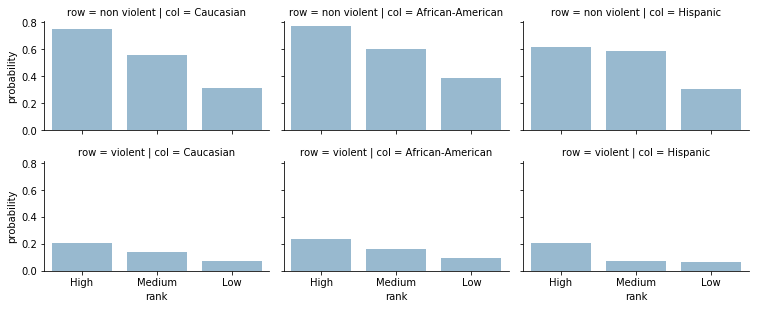

In [ ]:
grid = sns.FacetGrid(Join1, row='row', col='col', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'rank', 'probability', alpha=.5, ci=None)
grid.add_legend()

>1.4.2 Compute the False Positive Rate for each race: what fraction of defendants who do not recidivate receive a high risk score?

>1.4.3 Compute the False Negative Rate for each race: what fraction of defendants who do recidivate receive a low risk score?

>1.4.4 Compute the Positive Predictive Value (or Precision) for each race.

>1.4.5 Compute the Negative Predictive Value for each race (what fraction of low-risk defendants don’t recidiviate).

All of the above are computed below together

To compute the precision, False positive rate, false negative rate, negative predictive value based on the race and differentiate in the score_text and v_score_text we will replace the "High" value as 1 whereas "Medium" and "Low" value as 0. Once this steps have been done we have selected seperately for 3 different race. For each race we have then calculated precision, false positive rate, false negative rate and negative predictive value

In [ ]:
a2 = data1[['race','score_text','v_score_text', 'is_recid','is_violent_recid','decile_score','v_decile_score']]

a2.loc[a2['score_text']=='High', 'score_text'] =1
a2.loc[a2['score_text']=='Medium', 'score_text'] =0
a2.loc[a2['score_text']=='Low', 'score_text'] =0

a2.loc[a2['v_score_text']=='High', 'v_score_text'] =1
a2.loc[a2['v_score_text']=='Medium', 'v_score_text'] =0
a2.loc[a2['v_score_text']=='Low', 'v_score_text'] =0

a3_Caucasian = a2 [a2['race']=='Caucasian']
a3_Caucasian.head()
a3_African_American = a2 [a2['race']=='African-American']
a3_African_American .head()
a3_Hispanic = a2 [a2['race']=='Hispanic']

C:\Users\Sajon_PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


**General recividism for Caucasian**

In [ ]:
confusion_matrix = pd.crosstab(a3_Caucasian['is_recid'], a3_Caucasian['score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd = pd.DataFrame()
dd['non violent'] = [pre, FPR, FNR, NPR]
dd['stats'] = ['pre', 'FPR', 'FNR', 'NPR']
dd['race'] = ['Caucasian', 'Caucasian', 'Caucasian', 'Caucasian']
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.045565500406834825
False Negative Rate is:  0.8089244851258581
Positive predictive value / precsion is:  0.7488789237668162
Negative predictive value is:  0.6239361702127659


**Violent for Caucasian**

In [ ]:
confusion_matrix = pd.crosstab(a3_Caucasian['is_violent_recid'], a3_Caucasian['v_score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd['violent'] = [pre, FPR, FNR, NPR]
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.040166927490871154
False Negative Rate is:  0.8924731182795699
Positive predictive value / precsion is:  0.20618556701030927
Negative predictive value is:  0.9172482552342971


**General recividism for African_American (Black)**

In [ ]:
confusion_matrix = pd.crosstab(a3_African_American['is_recid'], a3_African_American['score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd1 = pd.DataFrame()
dd1['non violent'] = [pre, FPR, FNR, NPR]
dd1['stats'] = ['pre', 'FPR', 'FNR', 'NPR']
dd1['race'] = ['African_American', 'African_American', 'African_American', 'African_American']
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.1355206847360913
False Negative Rate is:  0.6305696559503666
Positive predictive value / precsion is:  0.7751479289940828
Negative predictive value is:  0.5201716738197425


**Violent for African_American (Black)**

In [ ]:
confusion_matrix = pd.crosstab(a3_African_American['is_violent_recid'], a3_African_American['v_score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd1['violent'] = [pre, FPR, FNR, NPR]
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.121498726809749
False Negative Rate is:  0.7535211267605634
Positive predictive value / precsion is:  0.23917995444191345
Negative predictive value is:  0.8826754385964912


**General recividism for Hispanic**

In [ ]:
confusion_matrix = pd.crosstab(a3_Hispanic['is_recid'], a3_Hispanic['score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd2 = pd.DataFrame()
dd2['non violent'] = [pre, FPR, FNR, NPR]
dd2['stats'] = ['pre', 'FPR', 'FNR', 'NPR']
dd2['race'] = ['Hispanic', 'Hispanic', 'Hispanic', 'Hispanic']
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.057692307692307696
False Negative Rate is:  0.8527918781725888
Positive predictive value / precsion is:  0.6170212765957447
Negative predictive value is:  0.6363636363636364


**Violent for Hispanic**

In [ ]:
confusion_matrix = pd.crosstab(a3_Hispanic['is_violent_recid'], a3_Hispanic['v_score_text'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
FN = confusion_matrix.loc[1, 0]
TN = confusion_matrix.loc[0, 0]
recall = TP / (TP + FN)
pre = TP / (TP + FP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
NPR = TN / (TN + FN )
dd2['violent'] = [pre, FPR, FNR, NPR]
print('False Positive Rate is: ', FPR)
print('False Negative Rate is: ', FNR)
print('Positive predictive value / precsion is: ', pre)
print('Negative predictive value is: ', NPR)

False Positive Rate is:  0.04883227176220807
False Negative Rate is:  0.8421052631578947
Positive predictive value / precsion is:  0.20689655172413793
Negative predictive value is:  0.9333333333333333


> Plot ROC curves for each race (overlayed on top of each other — map the color and linetype aesthetics to race).

**ROC curve for General Recividism**

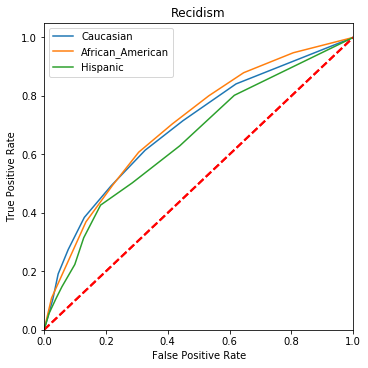

In [ ]:
a3_Caucasian.loc[:, ['is_recid', 'decile_score']]
fig, axs = plt.subplots(figsize=(5, 5), constrained_layout=True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
fpr, tpr, _ = metrics.roc_curve(a3_Caucasian['is_recid'], a3_Caucasian['decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='Caucasian')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', alpha=.8)
axs.set(title = 'Recidism', xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')

a3_African_American.loc[:, ['is_recid', 'decile_score']]
fpr, tpr, _ = metrics.roc_curve(a3_African_American['is_recid'], a3_African_American['decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='African_American')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', alpha=.8)

a3_Hispanic.loc[:, ['is_recid', 'decile_score']]
fpr, tpr, _ = metrics.roc_curve(a3_Hispanic['is_recid'], a3_Hispanic['decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='Hispanic')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', alpha=.8)
plt.legend()
plt.show();

The above plot shows the ROC curve for General recividism for all 3 races. From the model its visible that cacussian and african had alsmost similarly performance whereas the hispanic one perfromed slightly bad comparing to the other two. So the sensitivity or precision value was higher for cacussian and african american compared to hispanic race 

**ROC curve for Violent Recividism**

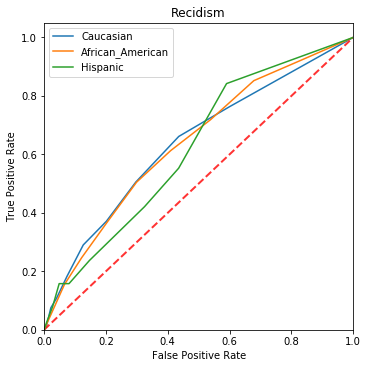

In [ ]:
a3_Caucasian.loc[:, ['is_recid', 'decile_score']]
fig, axs = plt.subplots(figsize=(5, 5), constrained_layout=True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
fpr, tpr, _ = metrics.roc_curve(a3_Caucasian['is_violent_recid'], a3_Caucasian['v_decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='Caucasian')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', alpha=.8)
axs.set(title = 'Recidism', xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')

a3_African_American.loc[:, ['is_recid', 'decile_score']]
fpr, tpr, _ = metrics.roc_curve(a3_African_American['is_violent_recid'], a3_African_American['v_decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='African_American')

a3_Hispanic.loc[:, ['is_recid', 'decile_score']]
fpr, tpr, _ = metrics.roc_curve(a3_Hispanic['is_violent_recid'], a3_Hispanic['v_decile_score'])
sns.lineplot(fpr, tpr, drawstyle='default', ax=axs, label='Hispanic')
plt.legend()
plt.show();

The above plot shows the ROC curve for violent recividism for all 3 races. From the model its visible that like the general one cacussian and african had alsmost similar performance whereas the hispanic one perfromed slightly bad comparing to the other two. So the sensitivity or precision value was higher for cacussian and african american compared to hispanic race

### 1.5 — Reflection and Analysis

> 1.5.1 How do defendants of different races experience the prediction system? Write 1-3 paragraphs about this, using your analysis in 1.4 as the factual basis of your argument.

Lets put together all the precision, false positive rate, false negative rate, negative predictive value together for the 3 races in a dataframe for ease of visualization

In [ ]:
dd3 = [dd, dd1, dd2]
dd3 = pd.concat(dd3)
dd3 = dd3[['non violent', 'violent', 'stats', 'race']]
dd3

,non violent,violent,stats,race
0,0.748879,0.206186,pre,Caucasian
1,0.045566,0.040167,FPR,Caucasian
2,0.808924,0.892473,FNR,Caucasian
3,0.623936,0.917248,NPR,Caucasian
0,0.775148,0.239180,pre,African_American
1,0.135521,0.121499,FPR,African_American
2,0.630570,0.753521,FNR,African_American
3,0.520172,0.882675,NPR,African_American
0,0.617021,0.206897,pre,Hispanic
1,0.057692,0.048832,FPR,Hispanic


**Cacussian:**

i. The reacall in general case is 0.74, whereas for violent is 0.20, so again the amount of FP is higher incase of violent, so a potential violent criminal would escape due to the false positive tag. 

ii. The false positive rate is 0.04 in both case which is comparatively lower and good because TN is higher, so in both cases it have succesfully predicted a negative as negative

iii. 
The false negative rate is 0.80 and 0.89 in general and violent case. Ideally the lower the value the better because higher value means lower Tp, so the model has failed to predict a potential general or violent crime occurer on many occasions.

iv. The negative predictive value is better if its high, for general and violent the values are 0.62 & 0.91. So its better in the violent case 

**African_American (Black)**


i. The recall is 0.77 for general and 0.23 for violent, almost similar result like cacussian, the FP would be lower in general but higher in violent, so a potential violent criminal would escape due to the false positive tag

ii. The false positive rate is 0.13 for general and 0.12 for violent case which is comparatively higher than the cacussian case, so in both cases it have less succesfully predicted a negative as negative compared to the cacussian race

iii. The false negative rate is 0.63 and 0.75 in general and violent case. Ideally the lower the value the better because higher value means lower Tp, so the model has failed to predict a potential general or violent crime occurer on many occasions, but it has performed better than the results in the cacussian race

iv. The negative predictive rate is 0.52 and 0.88 for general and violent case, so the higher value is for violent, so there is less amount of FN in violent case, comrared to general case

**Hispanic**
 

i. The recall is 0.61 for general and 0.20 for violent, the FP would be lower in general but higher in violent, so a potential violent criminal would escape due to the false positive tag 

ii. The false positive rate is 0.05 for general and 0.04 for violent case which is comparatively lower than the black but similar to cacussian case, so in both cases it have succesfully predicted a negative as negative 

iii. The false negative rate is 0.85 and 0.84 in general and violent case. Ideally the lower the value the better because higher value means lower Tp, so the model has failed to predict a potential general or violent crime occurer on most occasions like the cacussian race

iv. The negative predictive rate is 0.63 and 0.93 for general and violent case, so the higher value is for violent, so there is less amount of FN in violent case, comrared to general case

> 1.5.2 Why do you think these metrics tell different stories? How can PPV be similar but FPR and FNR be different? Write 1-2 paragraphs.

The metrix are almost similar cacusian and African american (black) but different for hispanic. I think the FPR and FNR are different becuase here the TP is much lower in comparison to the TN which makes FNR significantly higher than the FPR. Its visible in all the cases. Thats why the FPR and FNR are so different whereas PPV is much similar between the races as the model can predict those well. 

## Part 2: Simulation Analysis

To better understand how different metrics relate, and how they can lead to (un)fairness, you will now carry out a small simulation study. Simulations are useful because they allow us to examine how statistical techniques will behave under conditions we can completely control; by varying those conditions, and seeing how the technique’s results change, we can gain insight into how they behave with real data.

### The Setup

> Your simulation will be set up as follows:
There are two groups of metahumans, werewolves and vampires.
Each metahuman x will have a risk r(x) of attacking a human and a group g(x) (one of ‘werewolf’ or ‘vampire’). The risk is a probability: P(attack|r(x))=r(x)
Based on the risk r(x), the warden will decide whether to detain or release the metahuman.


**A Note on Realism:** the issues we are dealing with when discussing matters of justice, equity, and fairness are very serious. Reducing them to fictional groups, especially humorous ones, runs the risk of trivializing the problem. On the other hand, when we are experimenting with different risk levels and hypothetical, doing so in the context of actual human groups involves saying things about actual humans that may not bear any relation to reality. I am therefore using fictional groups, so we can discuss the mathematics of the problem without implicating the criminality of real people groups; in our class discussions, we will draw connections to apply what we learn from this fictional setting to problems in the real world.


### Technical Details

In [ ]:
def sample_probs(mean, conc, n=10000):
    alpha = mean * conc
    beta = (1 - mean) * conc
    return np.random.beta(alpha, beta, n)

### Warm-up: Identical Distributions

Set up a population that consists of 10000 werewolves and 10000 vampires; both groups have a mean risk of 0.2 and a concentration of 15. Generate the ‘attack’ variable as described above for each.

In [ ]:
vampires_risk = sample_probs(0.2, 15)
vampires_attack = np.random.binomial(2, vampires_risk).astype('bool')
print('verify that approximately 30% of the vampires attacked: ', vampires_attack.mean())

werewolves_risk = sample_probs(0.2, 15)
werewolves_attack = np.random.binomial(2, werewolves_risk).astype('bool')
print('verify that approximately 30% of the werewolves attacked: ', werewolves_attack.mean())

verify that approximately 30% of the vampires attacked:  0.3526
verify that approximately 30% of the werewolves attacked:  0.35


Create appropriate dataframe for further analysis

In [ ]:
W_risk = pd.DataFrame()
W_risk['risk'] = werewolves_risk
W_risk['attack'] = werewolves_attack
W_risk['race'] = 'werewolves'
V_risk = pd.DataFrame()
V_risk['risk'] = vampires_risk
V_risk['attack'] = vampires_attack
V_risk['race'] = 'vampires'
Total_risk = pd.concat([W_risk,V_risk]).reset_index(drop=True)
#Total_risk.tail()

We will use this to check that our analysis correctly finds no meaningful difference in treatment for two identical groups, and to 


1. Show the distribution of each group’s risk scores. This is a good way:

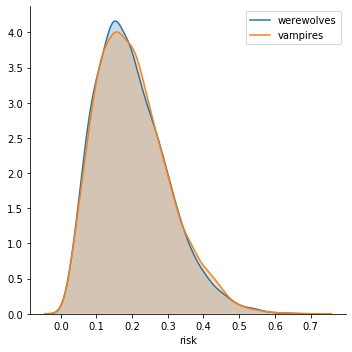

In [ ]:
grid = sns.FacetGrid(hue='race', data=Total_risk, size= 5)
grid.map(sns.kdeplot, 'risk', shade=True)
plt.legend()

The histograms indicate that the paramteres of distribution of both werewolfs and vampires are virtually identical.

2. Find a threshold value so that we detain 30% of the metahumans. This can be done by calling the Pandas ‘quantile’ method on ‘risk’: metas['risk'].quantile(0.7) will find the threshold.

In [ ]:
Ta = Total_risk['risk'].quantile(0.7)
print('threshold value that we detain 30% of the metahumans: ', Ta)

threshold value that we detain 30% of the metahumans:  0.2433188097003204


3. Create a ‘detain’ column, so that any metahuman with a risk that exceeds the threshold is detained.

In [ ]:
Total_risk['detain'] = Total_risk['risk'] > Ta
#Total_risk['detain'].head()

4. Using ‘detain’ as the decision (or classification), and attack as the outcome, compute the Detention Rate (fraction of the group detained, Positive Predictive Value (precision), and FPR for each group. Show this in a bar chart (X axis should be Metric, Y axis the value, and use different colors for groups; a Seaborn barplot can do this if you have an appropriately stacked data frame).

In [ ]:
FGD = Total_risk['detain'].mean()
print('fraction of the group detained: ', FGD)

fraction of the group detained:  0.3


In [ ]:
Total_risk['detain'] = Total_risk['detain'] * 1
Total_risk['attack'] = Total_risk['attack'] * 1
Total_risk_V = Total_risk[Total_risk['race'] == 'vampires']
Total_risk_W = Total_risk[Total_risk['race'] != 'vampires']
#Total_risk_W.head()

create a conducion matrix for both vampires and warewolfs

In [ ]:
confusion_matrix_V = pd.crosstab(Total_risk_V['attack'], Total_risk_V['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_V

Predicted,0,1
Actual,,
0,5096,1378
1,1863,1663


In [ ]:
confusion_matrix_W = pd.crosstab(Total_risk_W['attack'], Total_risk_W['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_W

Predicted,0,1
Actual,,
0,5126,1374
1,1915,1585


A function to calculate the stats

In [ ]:
def Stats101(confusion_matrix):
    TP = confusion_matrix.loc[1, 1]
    FP = confusion_matrix.loc[0, 1]
    FN = confusion_matrix.loc[1, 0]
    TN = confusion_matrix.loc[0, 0]
    recall = TP / (TP + FN)
    pre = TP / (TP + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    print('Recall is: ', recall)
    print('precsiion is: ', pre)
    print('Fals Positive Rate is: ', FPR)
    print('False Negative Rate is: ', FNR)
    return [recall, pre, FPR, FNR]

The Vampire stats:

In [ ]:
Vstat = Stats101(confusion_matrix_V)

Recall is:  0.4716392512762337
precsiion is:  0.546859585662611
Fals Positive Rate is:  0.21285140562248997
False Negative Rate is:  0.5283607487237663


The Warewolf stats:

In [ ]:
Wstat = Stats101(confusion_matrix_W)

Recall is:  0.45285714285714285
precsiion is:  0.535653937140926
Fals Positive Rate is:  0.2113846153846154
False Negative Rate is:  0.5471428571428572


create a new dataframe for bar plot

In [ ]:
st= pd.DataFrame()
st1 = pd.Series(Vstat)
st2 = pd.Series(Wstat)
st['values'] = pd.concat([st1, st2]).reset_index(drop=True)
st['stats'] = ['Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate', 'Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate']
st['race'] = ['vampires', 'vampires', 'vampires', 'vampires', 'werewolves', 'werewolves', 'werewolves', 'werewolves']

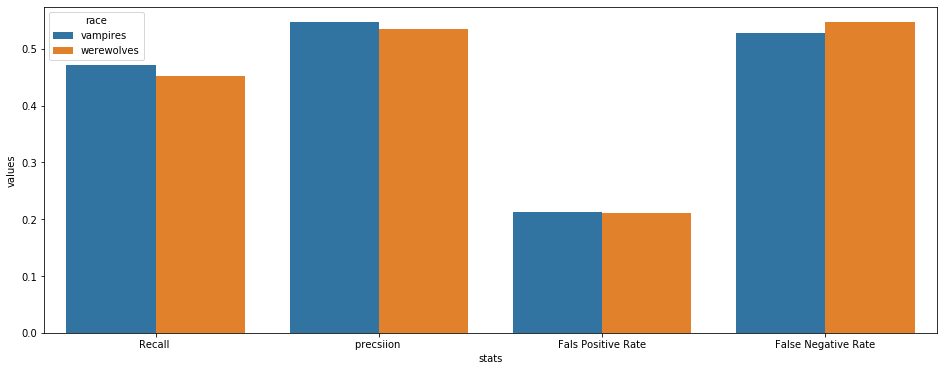

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="stats", y="values", hue="race", data=st)

As expected the stats (e.g., Recall, percision, FPR, and FNR) of the two metahumans are vertually identical because of haveing the same distribution with identical parameters. Furthemore it can be seen that the precision is near 50% which is equavilant to random guesing and that means our predictions are not accurate at all. False Positive Rate is low on the other hand therefore, the probability that false alerts will be raised is low. 

### Scenario 1: Different Means

> Re-run the simulation and analysis where werewolves have a mean risk of 0.25 and vampires have a mean risk of 0.15, and both groups have a concentration of 15.


What do you observe about the relationships of different metrics? What does this mean for metahumans?

In [ ]:
vampires_risk = sample_probs(0.15, 15)
vampires_attack = np.random.binomial(3, vampires_risk).astype('bool')
print('verify that approximately 30% of the vampires attacked: ', vampires_attack.mean())

werewolves_risk = sample_probs(0.25, 15)
werewolves_attack = np.random.binomial(2, werewolves_risk).astype('bool')
print('verify that approximately 30% of the werewolves attacked: ', werewolves_attack.mean())

verify that approximately 30% of the vampires attacked:  0.3659
verify that approximately 30% of the werewolves attacked:  0.4422


Create appropriate dataframe for further analysis

In [ ]:
W_risk = pd.DataFrame()
W_risk['risk'] = werewolves_risk
W_risk['attack'] = werewolves_attack
W_risk['race'] = 'werewolves'
V_risk = pd.DataFrame()
V_risk['risk'] = vampires_risk
V_risk['attack'] = vampires_attack
V_risk['race'] = 'vampires'
Total_risk = pd.concat([W_risk,V_risk]).reset_index(drop=True)
#Total_risk.tail()

1. Show the distribution of each group’s risk scores. This is a good way:

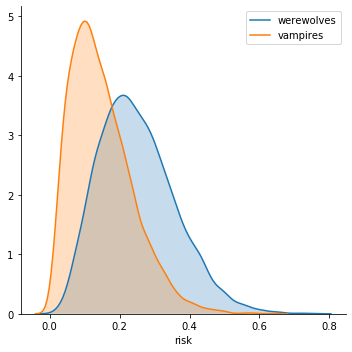

In [ ]:
grid = sns.FacetGrid(hue='race', data=Total_risk, size= 5)
grid.map(sns.kdeplot, 'risk', shade=True)
plt.legend()

So here, wareWolfs distribution has a higher mean compared to vampires therefore the distribution is more spread

2. Find a threshold value so that we detain 30% of the metahumans. This can be done by calling the Pandas ‘quantile’ method on ‘risk’: metas['risk'].quantile(0.7) will find the threshold.

In [ ]:
Ta = Total_risk['risk'].quantile(0.7)
print('threshold value that we detain 30% of the metahumans: ', Ta)

threshold value that we detain 30% of the metahumans:  0.2484429306173603


3. Create a ‘detain’ column, so that any metahuman with a risk that exceeds the threshold is detained.

In [ ]:
Total_risk['detain'] = Total_risk['risk'] > Ta
#Total_risk['detain'].head()

4. Using ‘detain’ as the decision (or classification), and attack as the outcome, compute the Detention Rate (fraction of the group detained, Positive Predictive Value (precision), and FPR for each group. Show this in a bar chart (X axis should be Metric, Y axis the value, and use different colors for groups; a Seaborn barplot can do this if you have an appropriately stacked data frame).

In [ ]:
FGD = Total_risk['detain'].mean()
print('fraction of the group detained: ', FGD)

fraction of the group detained:  0.3


create a conducion matrix for both vampires and warewolfs

In [ ]:
Total_risk['detain'] = Total_risk['detain'] * 1
Total_risk['attack'] = Total_risk['attack'] * 1
Total_risk_V = Total_risk[Total_risk['race'] == 'vampires']
Total_risk_W = Total_risk[Total_risk['race'] != 'vampires']
confusion_matrix_V = pd.crosstab(Total_risk_V['attack'], Total_risk_V['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_V

Predicted,0,1
Actual,,
0,5901,440
1,2786,873


In [ ]:
confusion_matrix_W = pd.crosstab(Total_risk_W['attack'], Total_risk_W['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_W

Predicted,0,1
Actual,,
0,3595,1983
1,1718,2704


The Vampire stats:

In [ ]:
Vstat = Stats101(confusion_matrix_V)

Recall is:  0.23858977862804046
precsiion is:  0.6648895658796649
Fals Positive Rate is:  0.06938968616937391
False Negative Rate is:  0.7614102213719596


The Warewolfs stats:

In [ ]:
Wstat = Stats101(confusion_matrix_W)

Recall is:  0.6114880144730891
precsiion is:  0.5769148709195647
Fals Positive Rate is:  0.3555037647902474
False Negative Rate is:  0.3885119855269109


create a new dataframe for bar plot

In [ ]:
st= pd.DataFrame()
st1 = pd.Series(Vstat)
st2 = pd.Series(Wstat)
st['values'] = pd.concat([st1, st2]).reset_index(drop=True)
st['stats'] = ['Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate', 'Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate']
st['race'] = ['vampires', 'vampires', 'vampires', 'vampires', 'werewolves', 'werewolves', 'werewolves', 'werewolves']

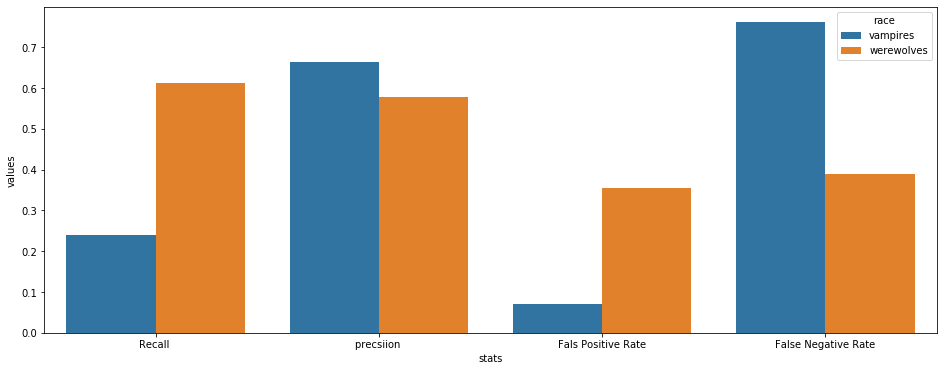

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="stats", y="values", hue="race", data=st)

recall is low and precision is high for vapmires and this shows that our classifier is very picky, and does not think many cases are vampires attacks and it also misses a lot of actual attacks. in case of warewolfs oOur classifier is very good, it is very picky, but still it gets almost all of the attacks so it does a better job. False Positive Rate is lower in vampires compared to warewolfs therefore, the probability that false alerts will be raised is lower in vampires but fase negative rates is the exact reverse. 

### Scenario 2: Same Mean

> Re-run the simulation and analysis where both groups have a mean risk of 0.2, but werewolves have a concentration of 20 and vampires have a concentration of 5.


What do you observe about the relationships of risk distributions and metrics between the groups? What does this mean for metahumans?

In [ ]:
vampires_risk = sample_probs(0.2, 5)
vampires_attack = np.random.binomial(2, vampires_risk).astype('bool')
print('verify that approximately 30% of the vampires attacked: ', vampires_attack.mean())

werewolves_risk = sample_probs(0.2, 20)
werewolves_attack = np.random.binomial(2, werewolves_risk).astype('bool')
print('verify that approximately 30% of the werewolves attacked: ', werewolves_attack.mean())

verify that approximately 30% of the vampires attacked:  0.3368
verify that approximately 30% of the werewolves attacked:  0.3498


Create appropriate dataframe for further analysis

In [ ]:
W_risk = pd.DataFrame()
W_risk['risk'] = werewolves_risk
W_risk['attack'] = werewolves_attack
W_risk['race'] = 'werewolves'
V_risk = pd.DataFrame()
V_risk['risk'] = vampires_risk
V_risk['attack'] = vampires_attack
V_risk['race'] = 'vampires'
Total_risk = pd.concat([W_risk,V_risk]).reset_index(drop=True)
#Total_risk.tail()

1. Show the distribution of each group’s risk scores. This is a good way:

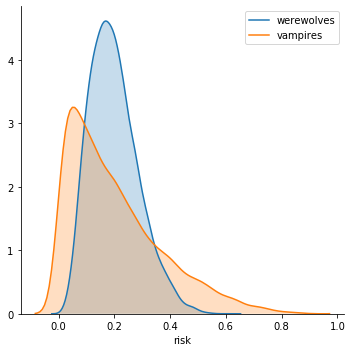

In [ ]:
grid = sns.FacetGrid(hue='race', data=Total_risk, size= 5)
grid.map(sns.kdeplot, 'risk', shade=True)
plt.legend()

So here, wareWolfs distribution has a higher number of concentration compared to vampires therefore the distribution is more spread

2. Find a threshold value so that we detain 30% of the metahumans. This can be done by calling the Pandas ‘quantile’ method on ‘risk’: metas['risk'].quantile(0.7) will find the threshold.

In [ ]:
Ta = Total_risk['risk'].quantile(0.7)
print('threshold value that we detain 30% of the metahumans: ', Ta)

threshold value that we detain 30% of the metahumans:  0.2449932300116177


3. Create a ‘detain’ column, so that any metahuman with a risk that exceeds the threshold is detained.

In [ ]:
Total_risk['detain'] = Total_risk['risk'] > Ta
#Total_risk['detain'].head()

4. Using ‘detain’ as the decision (or classification), and attack as the outcome, compute the Detention Rate (fraction of the group detained, Positive Predictive Value (precision), and FPR for each group. Show this in a bar chart (X axis should be Metric, Y axis the value, and use different colors for groups; a Seaborn barplot can do this if you have an appropriately stacked data frame).

In [ ]:
FGD = Total_risk['detain'].mean()
print('fraction of the group detained: ', FGD)

fraction of the group detained:  0.3


create a conducion matrix for both vampires and warewolfs

In [ ]:
Total_risk['detain'] = Total_risk['detain'] * 1
Total_risk['attack'] = Total_risk['attack'] * 1
Total_risk_V = Total_risk[Total_risk['race'] == 'vampires']
Total_risk_W = Total_risk[Total_risk['race'] != 'vampires']
confusion_matrix_V = pd.crosstab(Total_risk_V['attack'], Total_risk_V['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_V

Predicted,0,1
Actual,,
0,5386,1246
1,1330,2038


In [ ]:
confusion_matrix_W = pd.crosstab(Total_risk_W['attack'], Total_risk_W['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_W

Predicted,0,1
Actual,,
0,5221,1281
1,2063,1435


The Vampire stats:

In [ ]:
Vstat = Stats101(confusion_matrix_V)

Recall is:  0.6051068883610451
precsiion is:  0.620584652862363
Fals Positive Rate is:  0.18787696019300362
False Negative Rate is:  0.39489311163895485


The Warewolfs stats:

In [ ]:
Wstat = Stats101(confusion_matrix_W)

Recall is:  0.4102344196683819
precsiion is:  0.5283505154639175
Fals Positive Rate is:  0.19701630267609965
False Negative Rate is:  0.5897655803316181


create a new dataframe for bar plot

In [ ]:
st= pd.DataFrame()
st1 = pd.Series(Vstat)
st2 = pd.Series(Wstat)
st['values'] = pd.concat([st1, st2]).reset_index(drop=True)
st['stats'] = ['Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate', 'Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate']
st['race'] = ['vampires', 'vampires', 'vampires', 'vampires', 'werewolves', 'werewolves', 'werewolves', 'werewolves']

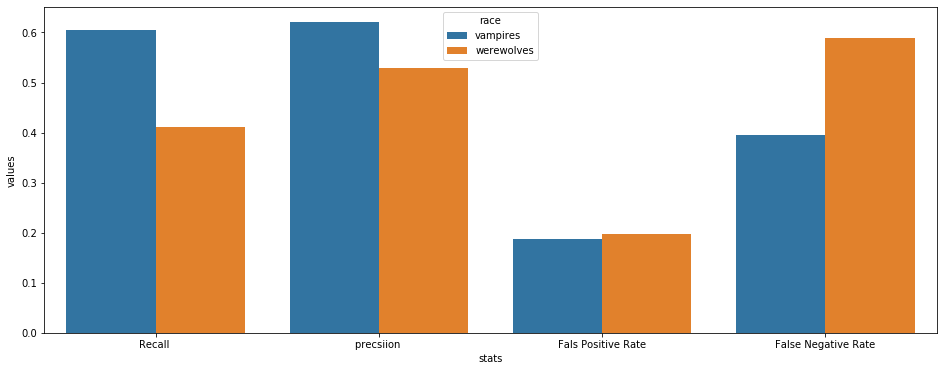

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="stats", y="values", hue="race", data=st)

recall and precision is high for both vapmires and werewolfs and this shows that our classifier is very picky and classifier is very good. But in general vampires in this case has higher values of precision and recall while having lower values of FPR and FNR, therefore indicating that these two parameters of binomial distribution are much more suited for our classifier.

### Scenario 3: Different Sample Sizes

> Re-run the simulation and analysis where both groups have a concentration of 10, but there are 5000 werewolves with mean risk of 0.2 and 20000 vampires with mean risk of 0.15.

What do you observe about the relationships of risk distributions and metrics between the groups? What does this mean for metahumans?

In [ ]:
vampires_risk = sample_probs(0.15, 10, n=20000)
vampires_attack = np.random.binomial(3, vampires_risk).astype('bool')
print('verify that approximately 30% of the vampires attacked: ', vampires_attack.mean())

werewolves_risk = sample_probs(0.2, 10, n=5000)
werewolves_attack = np.random.binomial(2, werewolves_risk).astype('bool')
print('verify that approximately 30% of the werewolves attacked: ', werewolves_attack.mean())

verify that approximately 30% of the vampires attacked:  0.355
verify that approximately 30% of the werewolves attacked:  0.3564


Create appropriate dataframe for further analysis

In [ ]:
W_risk = pd.DataFrame()
W_risk['risk'] = werewolves_risk
W_risk['attack'] = werewolves_attack
W_risk['race'] = 'werewolves'
V_risk = pd.DataFrame()
V_risk['risk'] = vampires_risk
V_risk['attack'] = vampires_attack
V_risk['race'] = 'vampires'
Total_risk = pd.concat([W_risk,V_risk]).reset_index(drop=True)
#Total_risk.tail()

1. Show the distribution of each group’s risk scores. This is a good way:

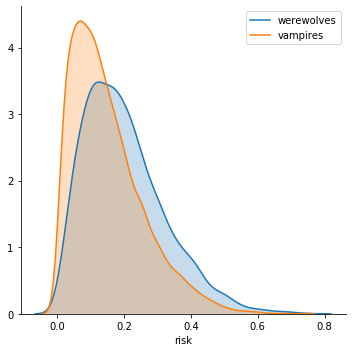

In [ ]:
grid = sns.FacetGrid(hue='race', data=Total_risk, size = 5)
grid.map(sns.kdeplot, 'risk', shade=True)
plt.legend()

2. Find a threshold value so that we detain 30% of the metahumans. This can be done by calling the Pandas ‘quantile’ method on ‘risk’: metas['risk'].quantile(0.7) will find the threshold.

In [ ]:
Ta = Total_risk['risk'].quantile(0.7)
print('threshold value that we detain 30% of the metahumans: ', Ta)

threshold value that we detain 30% of the metahumans:  0.20011568701123128


3. Create a ‘detain’ column, so that any metahuman with a risk that exceeds the threshold is detained.

In [ ]:
Total_risk['detain'] = Total_risk['risk'] > Ta
#Total_risk['detain'].head()

4. Using ‘detain’ as the decision (or classification), and attack as the outcome, compute the Detention Rate (fraction of the group detained, Positive Predictive Value (precision), and FPR for each group. Show this in a bar chart (X axis should be Metric, Y axis the value, and use different colors for groups; a Seaborn barplot can do this if you have an appropriately stacked data frame).

In [ ]:
FGD = Total_risk['detain'].mean()
print('fraction of the group detained: ', FGD)

fraction of the group detained:  0.3


create a conducion matrix for both vampires and warewolfs

In [ ]:
Total_risk['detain'] = Total_risk['detain'] * 1
Total_risk['attack'] = Total_risk['attack'] * 1
Total_risk_V = Total_risk[Total_risk['race'] == 'vampires']
Total_risk_W = Total_risk[Total_risk['race'] != 'vampires']
confusion_matrix_V = pd.crosstab(Total_risk_V['attack'], Total_risk_V['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_V

Predicted,0,1
Actual,,
0,10965,1935
1,3724,3376


In [ ]:
confusion_matrix_W = pd.crosstab(Total_risk_W['attack'], Total_risk_W['detain'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_W

Predicted,0,1
Actual,,
0,2177,1041
1,634,1148


The Vampire stats:

In [ ]:
Vstat = Stats101(confusion_matrix_V)

Recall is:  0.4754929577464789
precsiion is:  0.6356618339295801
Fals Positive Rate is:  0.15
False Negative Rate is:  0.5245070422535211


The Warewolfs stats:

In [ ]:
Wstat = Stats101(confusion_matrix_W)

Recall is:  0.6442199775533108
precsiion is:  0.5244403837368662
Fals Positive Rate is:  0.32349285270354255
False Negative Rate is:  0.3557800224466891


create a new dataframe for bar plot

In [ ]:
st= pd.DataFrame()
st1 = pd.Series(Vstat)
st2 = pd.Series(Wstat)
st['values'] = pd.concat([st1, st2]).reset_index(drop=True)
st['stats'] = ['Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate', 'Recall ', 'precsiion ', 'Fals Positive Rate', 'False Negative Rate']
st['race'] = ['vampires', 'vampires', 'vampires', 'vampires', 'werewolves', 'werewolves', 'werewolves', 'werewolves']

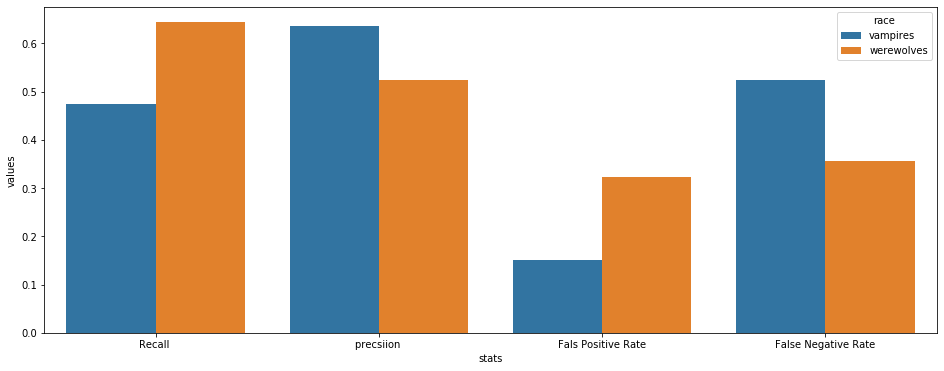

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="stats", y="values", hue="race", data=st)

Here we can see a tradeoff between [recall, precision] and [FPR, FNR] in both cases one has a higher recall whereas the other has higher precission. So in our case we want to currectly identify attacks so having a higher precision is prefered therefore the calssifier does a better job for  werewolfs and FPR and FNR are more balanced.

## Part 3: Conclusion

Write a paragraph about what you have learned through this exercise.

Through the exercise we have focused on couple of things

The first part actually tell us about different part of the confusion matrix and how we can use the values from the confusion matrix several parameters which finally gives us a idea about how our model is performing. For example we know that Presion is the ratio of TP/(TP+FP), so the higher value of precison indicates that an example labeled as positive is indeed positive. Similarly for Negative predictive rate should also be higher, because its the ratio of TN/(TN+FN), so the higher value of Negative predictive rate indicates that an example labeled as negative is indeed negative. Its also indicating the less amount of FN. Ideal value for both case should be 1 indicating FP & FN are 0 in the above 2 parameters
The scenario changes when we talk about False positive rate and False negative rate. In both cases best possible value is 0 and the worst value is 1. In Machine Learning, performance measurement is an essential task. Through the exercise we have got a strong understanding about how this parameters actually can be a strong indicator of model performances. 

Similarly ROC curve also gives a strong idea about the model by comparing the sensitivity (precsion) and false psoitive rate. Through the analysis we have also learnt about this curves and how more precision otherwise the curve to be more closer to the left and top corner of the plot indicates better performing model and curve closer to the bottom and right corner indicates bad model



So from the simulation classification analysis we found situations were a classification had the following results: 
Low recall, low precision where it indicated poor classification
Low recall, high precision where our classifier is very picky, and does not identify most attacks. However it also misses a lot of actual atacks, because it is so very picky.
High recall, high precision where our classifier is very good, it is very picky, but still it gets almost all of the attacks.
Therefore having both high prevision and recall indicates a better calssification and is more prefered 